<a href="https://www.kaggle.com/code/samithsachidanandan/face-mask-detection-cnn?scriptVersionId=291582968" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.

# Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")


import tensorflow as tf 
from tensorflow.keras import layers, models

2026-01-13 06:13:18.482701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768284798.855363      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768284798.957391      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768284799.808924      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768284799.808983      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768284799.808987      17 computation_placer.cc:177] computation placer alr

In [3]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32


DATA_DIR ='/kaggle/input/face-mask-detection/data'

In [4]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    shuffle = True, 
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
    )

Found 19345 files belonging to 2 classes.


2026-01-13 06:13:51.191734: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
class_names = dataset.class_names
class_names

['with_mask', 'without_mask']

In [6]:
len(dataset)

605

In [7]:
class_images = {}

for images, labels in dataset:
    for img, label in zip(images, labels):
        label = label.numpy()
        if label not in class_images:
            class_images[label] = img.numpy()
        if len(class_images) == len(class_names):
            break
    if len(class_images) == len(class_names):
        break

# Visualizing the samples

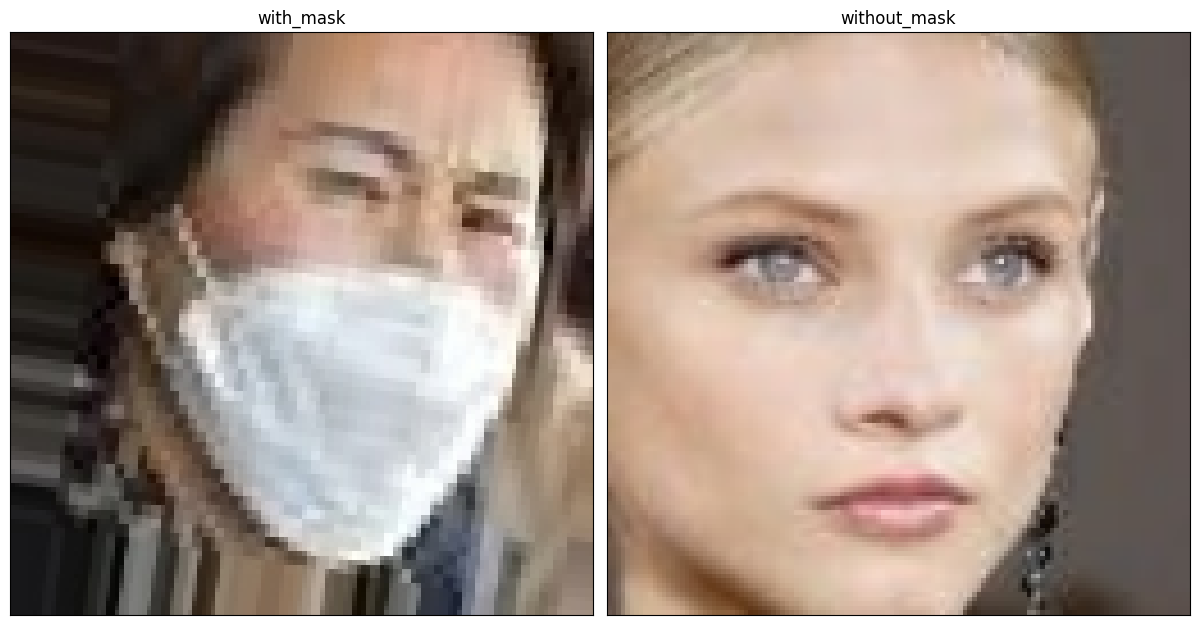

In [8]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 6),
    subplot_kw={'xticks': [], 'yticks': []}
)

for i, class_idx in enumerate(sorted(class_images.keys())):
    axes[i].imshow(class_images[class_idx].astype("uint8"))
    axes[i].set_title(class_names[class_idx], fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

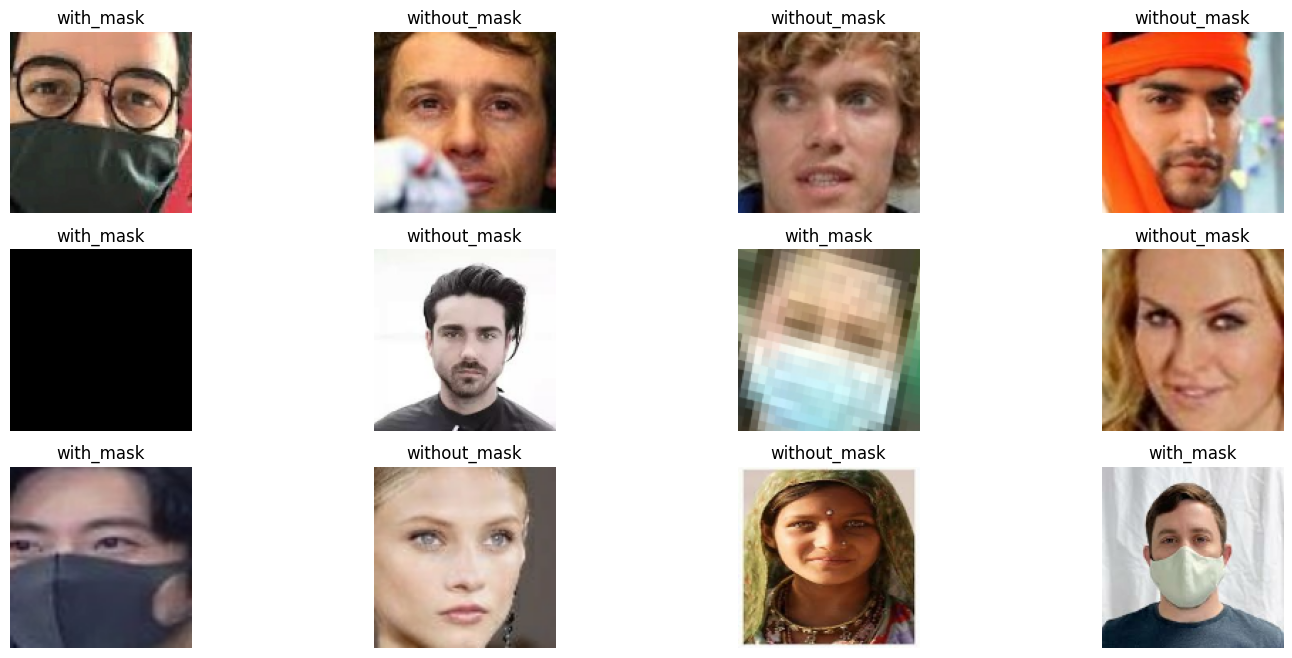

In [9]:
plt.figure(figsize=(18,8))
for image_batch, label_batch in dataset.take(1):

    num_images = min(12, len(image_batch)) 
    
    for i in range(num_images):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])   
        plt.axis('off')

# Train-Val-Test Split

In [10]:
def get_dataset_partitions_tf (ds,train_split=0.6, val_split=0.20, test_split=0.20, shuffle=True,shuffle_size=10000 ):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)



    return train_ds, val_ds, test_ds 

In [11]:
train_ds, val_ds,test_ds = get_dataset_partitions_tf(dataset)

# Normalization 

In [12]:
train_ds = train_ds.map(lambda x, y: (x/255,y))
test_ds = test_ds.map(lambda x, y: (x/255,y))
val_ds = val_ds.map(lambda x, y: (x/255,y))

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = test_ds.cache().prefetch(AUTOTUNE)
test_ds = val_ds.cache().prefetch(AUTOTUNE)

# Model 

In [14]:
for images, _ in dataset.take(1):
    CHANNELS = images.shape[-1]

input_shape = (*IMAGE_SIZE, CHANNELS)


model = models.Sequential([
    layers.Input(shape=input_shape), 
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),   

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
   

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid"),
])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,673 (471.38 KB)

 Trainable params: 119,905 (468.38 KB)

 Non-trainable params: 768 (3.00 KB)

In [16]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [18]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

# Training 

In [19]:
history = model.fit(
    train_ds,
    epochs=100,               
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 726s 2s/step - accuracy: 0.7825 - loss: 0.4927 - val_accuracy: 0.7562 - val_loss: 0.5544 - learning_rate: 0.0010
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - accuracy: 0.8770 - loss: 0.2952 - val_accuracy: 0.7627 - val_loss: 0.6343 - learning_rate: 0.0010
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 655s 2s/step - accuracy: 0.9275 - loss: 0.1878 - val_accuracy: 0.9225 - val_loss: 0.2094 - learning_rate: 0.0010
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 689s 2s/step - accuracy: 0.9515 - loss: 0.1353 - val_accuracy: 0.7198 - val_loss: 0.5806 - learning_rate: 0.0010
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.9601 - loss: 0.1156 - val_accuracy: 0.7812 - val_loss: 0.5470 - learning_rate: 0.0010
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.9656 - loss: 0.0969 - val_accuracy: 0.9256 - val_loss: 0.1977 - learning_rate: 0.0010
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.9658 - l

In [20]:
scores = model.evaluate(test_ds)

121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 329ms/step - accuracy: 0.9942 - loss: 0.0204


In [21]:
print(f"Test Accuracy: {scores[1]*100:.2f}%")

Test Accuracy: 99.38%


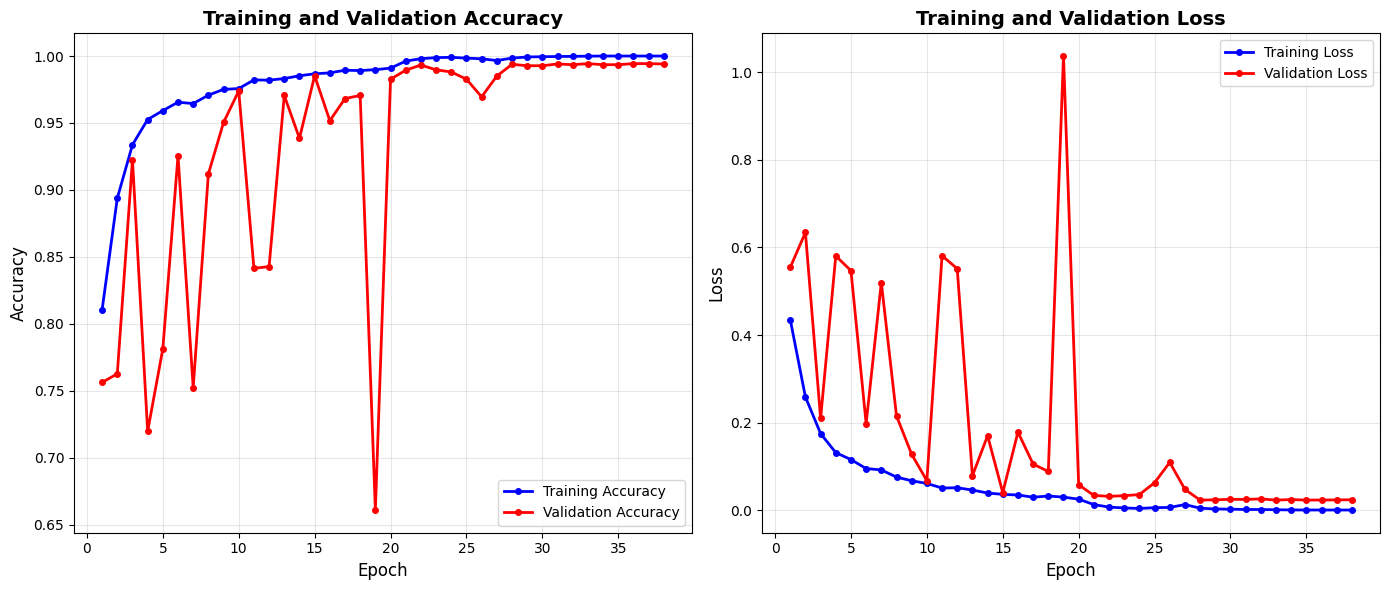


Training Summary:
Total epochs trained: 38
Best validation accuracy: 0.9943 (Epoch 33)
Final training accuracy: 1.0000
Final validation accuracy: 0.9941
Final training loss: 0.0003
Final validation loss: 0.0237



In [22]:
def plot_training_history(history):
    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    

    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_acc, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
  
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_loss, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
  
    total_epochs = len(acc)
    best_epoch = val_acc.index(max(val_acc)) + 1
    print(f"\n{'='*50}")
    print(f"Training Summary:")
    print(f"{'='*50}")
    print(f"Total epochs trained: {total_epochs}")
    print(f"Best validation accuracy: {max(val_acc):.4f} (Epoch {best_epoch})")
    print(f"Final training accuracy: {acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")
    print(f"Final training loss: {loss[-1]:.4f}")
    print(f"Final validation loss: {val_loss[-1]:.4f}")
    print(f"{'='*50}\n")



plot_training_history(history)